In [59]:
from lusidtools.jupyter_tools import toggle_code

"""Portfolio Entitlements

Demonstrates how to create policies/access control to various date items.

Attributes
----------
entitlements
"""

toggle_code("Toggle Docstring")

# Portfolio Entitlements Demonstration

# 1. Setup

## 1.1 API connections

In [60]:
# Import Libraries
import os
import json
import pytz

from datetime import datetime, timedelta

import finbourne_access
import finbourne_identity
import lusid
import lusid.models as lm
import pandas as pd
from lusid import ApiException
from datetime import date

from finbourne_access import models as access_models
from finbourne_identity import models as identity_models
from lusidjam import RefreshingToken
from IPython.core.display import HTML

# Set DataFrame display formats
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.options.display.float_format = "{:,.2f}".format
display(HTML("<style>.container { width:90% !important; }</style>"))

# Authenticate our user and create our API client
secrets_path = os.getenv("FBN_SECRETS_PATH")

lusid_api_factory = lusid.utilities.ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename=secrets_path,
    app_name="LusidJupyterNotebook",
)

api_client = lusid_api_factory.api_client

lusid_api_url = api_client.configuration.host
access_api_url = lusid_api_url[: lusid_api_url.rfind("/") + 1] + "access"
identity_api_url = lusid_api_url[: lusid_api_url.rfind("/") + 1] + "identity"

access_api_factory = finbourne_access.utilities.ApiClientFactory(
    token=api_client.configuration.access_token,
    access_url=access_api_url,
    app_name="LusidJupyterNotebook",
)

identity_api_factory = finbourne_identity.utilities.ApiClientFactory(
    token=api_client.configuration.access_token,
    api_url=identity_api_url,
    app_name="LusidJupyterNotebook",
)

api_status = pd.DataFrame(
    lusid_api_factory.build(lusid.api.ApplicationMetadataApi)
    .get_lusid_versions()
    .to_dict()
)

display(api_status)

,api_version,build_version,excel_version,links
0,v0,0.6.8407.0,0.5.2558,"{'relation': 'RequestLogs', 'href': 'http://fb..."


In [81]:
policies_api = access_api_factory.build(finbourne_access.PoliciesApi)
portfolios_api=lusid_api_factory.build(lusid.PortfoliosApi)
transactions_api= lusid_api_factory.build(lusid.TransactionPortfoliosApi)
access_roles_api = access_api_factory.build(finbourne_access.RolesApi)
identity_roles_api = identity_api_factory.build(finbourne_identity.RolesApi)
users_api = identity_api_factory.build(finbourne_identity.UsersApi)

## 1.2 Create Portfolios

In [82]:
def check_portfolio(code,scope):
    try:
        result= portfolios_api.delete_portfolio(code=code,scope=scope)
        return 'Portfolio successfully deleted'
    except ApiException as e:
        return 'Portfolio does not yet exist'

In [83]:
def create_portfolio(portfolio_code,scope='',display_name='',base_currency='GBP'):
    check_portfolio(portfolio_code,scope)
    request= lm.CreateTransactionPortfolioRequest(
        display_name=display_name,
        code=portfolio_code,
        base_currency=base_currency,
        created=str(date(2020,1,1)))
    try:
        result = transactions_api.create_portfolio(
            scope=scope,
            create_transaction_portfolio_request=request)
        return result
    except ApiException as e:
        display(json.loads(e.body)["title"])

In [84]:
def upsert_fx(scope, port_code, transaction_date=datetime(2021, 5, 24, tzinfo=pytz.utc)):
    T_id= 'Transaction_1'
    request= lm.TransactionRequest(
    transaction_id=T_id,
    type="FwdFxBuy",
    instrument_identifiers={"Instrument/default/Currency": 'GBP'},
    transaction_date=transaction_date.isoformat(),
    settlement_date=transaction_date.isoformat(),
    units=1000,
    transaction_price=lm.TransactionPrice(1,'Price'),
    total_consideration=lm.CurrencyAndAmount(10000,'GBP'))
    response= transactions_api.upsert_transactions(scope,
                                                   port_code,
                                                   transaction_request=[request])
    response= response.to_dict()
    display({'response link':response['links'][2]['href']})

In [85]:
port_1250_response=create_portfolio('1250',scope='Source1',display_name='Port 1250',base_currency='GBP')
port_1232_response=create_portfolio('1232',scope='Source2',display_name='Port 1232',base_currency='GBP')
port_6350_response=create_portfolio('6305',scope='Source3',display_name='Port 6305',base_currency='GBP')

In [86]:
upsert_fx('Source1','1250')
upsert_fx('Source3','6305', (datetime.now(tz=pytz.utc) + timedelta(days=-15)))

{'response link': 'http://fbn-ci.lusid.com/app/insights/logs/0HMECAD9UA96O:0000002A'}

{'response link': 'http://fbn-ci.lusid.com/app/insights/logs/0HMECAF3OB5S6:00000012'}

## 3.Policy and User Creation

Here we define the creation of policies with WhenSpec & ForSpec attributes. In this example, the policies are applied to a portfolio. We also create a policy collection, as well as users & roles. We then link a role with a policy.

For more information on policies & roles, refer to the [LUSID KB](https://support.lusid.com/knowledgebase/article/KA-01652/)

### 3.1 Policy Creation

In [87]:
# WhenSpec objects specify the "lifetime" of a modification:
# when it is activated and when it is deactivated.
when_spec = access_models.WhenSpec(
    activate=datetime.now(tz=pytz.utc) + timedelta(days=2),
    deactivate=datetime(2021, 12, 31, tzinfo=pytz.utc),
)

# ForSpec with an EffectiveDateRelative, in this case
# subtract x days from now, and compare that the effective
# date is BeforeOrOn.
# 
# See https://support.lusid.com/knowledgebase/article/KA-01831 for more info
# on bi-temporal data

for_spec = access_models.ForSpec(
    effective_date_relative=access_models.EffectiveDateRelative(
        date="Now",
        adjustment=(datetime.now(tz=pytz.utc) + timedelta(days=0)).strftime("-%j"),
        unit="Day",
        relative_to_date_time="BeforeOrOn"
    )
)

deactivate = datetime.now(tz=pytz.utc) + timedelta(days=50)

In [88]:
def return_when_spec(deactivate=deactivate,activate_delay=0):
    when_spec = access_models.WhenSpec(
        activate=datetime.now(tz=pytz.utc) + timedelta(days=activate_delay),
        deactivate=deactivate,
    )
    return when_spec

def return_for_spec(delay=0):
    for_spec = access_models.ForSpec(
        effective_date_relative=access_models.EffectiveDateRelative(
            date="Now",
            adjustment=(datetime.now(tz=pytz.utc) + timedelta(days=delay)).strftime("-%j"),
            unit="Day",
            relative_to_date_time="BeforeOrOn"
            )
    )
    return for_spec

In [89]:
def create_policy_portfolio_scope_access(scope,portfolio_code,deactivate=deactivate, for_specs=None, activate_delay=0):
    allow_portfolio_policy_code = f"allow-portfolio-access-{scope}-{portfolio_code}"
    portfolio_selector_definition = access_models.IdSelectorDefinition(
       identifier={"scope": scope, "code": portfolio_code},
       actions=[
          access_models.ActionId(scope="default", activity="Any", entity="Portfolio")
        ],
    )
    allow_portfolio_path = access_models.SelectorDefinition(
        id_selector_definition=portfolio_selector_definition)
    allow_portfolio_policy_request = access_models.PolicyCreationRequest(
        code=allow_portfolio_policy_code,
        applications=["LUSID"],
        grant="Allow",
        selectors=[allow_portfolio_path],
        _for=for_specs,
        when=return_when_spec(deactivate=deactivate),
     )
    try:
    # Create the policy.
        policies_api.create_policy(allow_portfolio_policy_request)
    except finbourne_access.ApiException as e:
        detail = json.loads(e.body)
        if detail['code'] not in [612,613,615]:
            raise e
    return allow_portfolio_policy_code

In [90]:
def return_selector_defitions(selector_list):
    sl=[access_models.SelectorDefinition(id_selector_definition=i) 
         for i in selector_list]
    return sl

In [91]:
def return_id_selector_definition_list(endpoint_codes,activity="Execute",entity="Feature"):
    id_ls=[]
    for i in endpoint_codes:
        IdSelector= access_models.IdSelectorDefinition(
             identifier={"scope": 'LUSID', "code": i},
             actions=[
             access_models.ActionId(scope="LUSID", activity=activity, entity=entity)
               ],
               name="run "+ i,
              description=i
              )
        id_ls.append(IdSelector)
    return id_ls

In [92]:
def create_policy_for_endpoint_access(endpoint_name,endpoint_codes,deactivate=deactivate, activate_delay=0):
    allow_endpoint_policy_code = f"allow-endpoint-access-{endpoint_name}"
    selectors=return_selector_defitions(return_id_selector_definition_list(endpoint_codes))
    allow_portfolio_policy_request = access_models.PolicyCreationRequest(
        code=allow_endpoint_policy_code,
        applications=["LUSID"],
        grant="Allow",
        selectors=selectors,
        when=return_when_spec(deactivate=deactivate),
     )
    try:
    # Create the policy.
        policies_api.create_policy(allow_portfolio_policy_request)
    except finbourne_access.ApiException as e:
        detail = json.loads(e.body)
        if detail['code'] not in [612,613,615]:
            raise e
    return allow_endpoint_policy_code

### 3.2 Policy Collection

In [93]:
def create_policy_collection(policy_codes,collection_code,description):
 #   policy_collection_code= f"allow-portfolio-access-{collection_code}"
    policy_id_list=[access_models.PolicyId('default',i) for i in policy_codes]
    policy_collection_request= access_models.PolicyCollectionCreationRequest(code=collection_code,policies=policy_id_list,description=description)
    try:
    # Create the policy collection.
        policies_api.create_policy_collection(policy_collection_request)
    except finbourne_access.ApiException as e:
        detail=json.loads(e.body)
        if detail['code'] not in [612,613,615]:
            raise e
    return collection_code

### 3.3 Role Creation 

In [94]:
def create_role(role_code,policy_collection_code,policy_code='tutorial-readonly-examplesdkapp-access',deactivate=deactivate):
    allow_features_policy_code = "allow-standard-lusid-features-access"

    # Create the role using the access API.
    role_creation_request = access_models.RoleCreationRequest(
        code=role_code,
        description=role_code,
        resource=access_models.RoleResourceRequest(
            policy_id_role_resource=access_models.PolicyIdRoleResource(
            # Here, we apply the two default policies when creating the role.
            policies=[
                access_models.PolicyId(scope="default", code=policy_code),
                ],
            policy_collections=[access_models.PolicyCollectionId(scope="default", code=policy_collection_code)]
             )
        ),
       when=return_when_spec(deactivate=deactivate),
       )
    try:
        response = access_roles_api.create_role(role_creation_request)
    except finbourne_access.ApiException as e:
        detail = json.loads(e.body)
        if detail['code'] not in [612,613,615]:  # RoleWithCodeAlreadyExists
            raise e
    # Create the same role using the identity API.
    try:
        response = identity_roles_api.create_role(
        create_role_request=identity_models.CreateRoleRequest(role_code)
          )
    except finbourne_identity.ApiException as e:
        detail=json.loads(e.body)
        if detail['code'] !=157:
            raise e

### 3.4 User Creation

In [95]:
def create_user_with_role(first_name, last_name, email, role_code):
    request= finbourne_identity.CreateUserRequest(first_name=first_name,
                                         last_name=last_name,email_address=email,login=email,
                                        roles=[identity_models.RoleId(scope="default", code=role_code)],type='Service')
    try:
        users_api.create_user(request)
        return 'User Created'
    except finbourne_identity.ApiException as e:
        detail=json.loads(e.body)
        if detail['code'] !=658:
            raise e

## 4. Set up information barriers

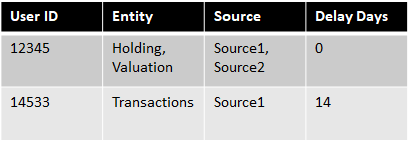

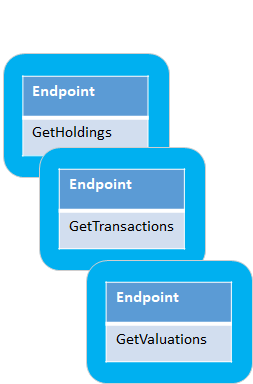

### 4.1 Create Feature Policies

Here we define the minimum set of feature policies which allow for this example to complete.
A feature policy defines the executions available on particular API endpoints across the lusid system.

You can find more information on feature policies, along with a detailed example, in the access control summary on the [LUSID KB](https://support.lusid.com/knowledgebase/article/KA-01652/#access-control-summary). 

In [96]:
holding_endpoint_codes=["api-searchproxy-searchportfolios", "api-portfolios-listportfolios", 
                        "api-portfolios-getportfolio","api-transactionportfolios-getdetails"
                       , "api-transactionportfolios-getholdings"]

transaction_endpoint_codes=["api-transactionportfolios-gettransactions","api-searchproxy-searchportfolios",
                            "api-portfolios-listportfolios",
                            "api-portfolios-getportfolio" ]

valuation_endpoint_codes= ["api-configurationrecipe-*"]

In [97]:
### Create the Policies that create access to different scopes and portfolio codes. These policies combine data from both the IB Fund Table and Entitlements Central. The two tables are joined based on the user ID.
source1_1250_policy_id=create_policy_portfolio_scope_access('Source1','1250')
source2_1250_policy_id=create_policy_portfolio_scope_access('Source2','1250')
source1_1232_policy_id=create_policy_portfolio_scope_access('Source1','1232')
source2_1232_policy_id=create_policy_portfolio_scope_access('Source2','1232')

# Create a policy with a forSpec of 'now' -14 days
source3_1250_policy_id=create_policy_portfolio_scope_access('Source3','1250', for_specs=[return_for_spec(14)])
source_1_6305_policy_id=create_policy_portfolio_scope_access('Source1','6305')
source_2_6305_policy_id=create_policy_portfolio_scope_access('Source2','6305')



### Endpoint policy ID for Access to portfolio Holdings
holding_policy_id=create_policy_for_endpoint_access('Holding',holding_endpoint_codes, activate_delay=0)

### Create policy for Valuations
valuation_policy_id=create_policy_for_endpoint_access('Valuation',valuation_endpoint_codes, activate_delay=0)

###Create policy for access to portfolio Transactions, delaying the activation of the policy for 14 days
transaction_policy_id=create_policy_for_endpoint_access('Transaction',transaction_endpoint_codes, activate_delay=14)

## 4.2 Create Policy Collections

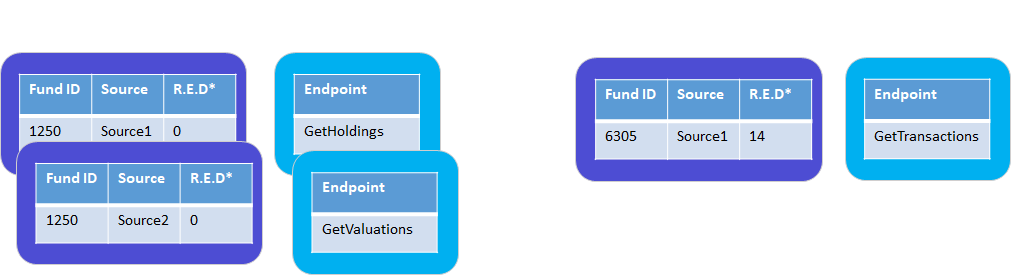

In [98]:
## Create Policy collection for user 12345
policy_collection_12345=create_policy_collection([source1_1250_policy_id, source2_1250_policy_id,source1_1232_policy_id,source2_1232_policy_id, holding_policy_id,valuation_policy_id ],'user_12345_collection','User 12345 Collection')

##Create Policy collection for user 14533
policy_collection_14533=create_policy_collection([source1_1250_policy_id, source_1_6305_policy_id,transaction_policy_id],'user_14533_collection','User 14533 Collection')

##Create Policy collection for user 15000
policy_collection_15000=create_policy_collection([source3_1250_policy_id,transaction_policy_id],'user_15000_collection','User 15000 Collection')

### 4.3 Create Roles

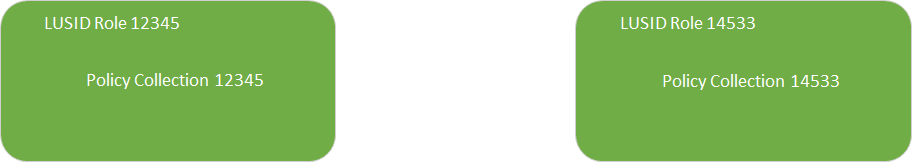

In [99]:
create_role('LUSID Role 12345','user_12345_collection')
create_role('LUSID Role 14533', 'user_14533_collection')
create_role('LUSID Role 15000', 'user_15000_collection')

### 4.4 Create Users with Roles Assigned

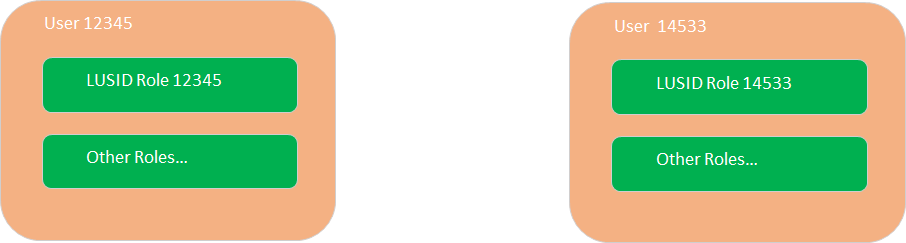

In [100]:
#Users will not work correctly without a valid email address. To set up a User please provide a valid email address and follow the user
#set up instructions.

### Create Users with roles, specify email address as welll as first names
create_user_with_role('12345','12345' , '12345@example.com','LUSID Role 12345')
create_user_with_role('14533','14533' ,'14533@example.com','LUSID Role 14533')

### 4.5 Complete

You will now have some example portfolios setup, with policies applied, along with users & roles.
You can now view these portfolios in the web portal.

(Note: ForSpec portfolios will not be visible in the web portal, this feature is not fully supported by the web portal at present. However you can still perform API requests to retreive the data you require).